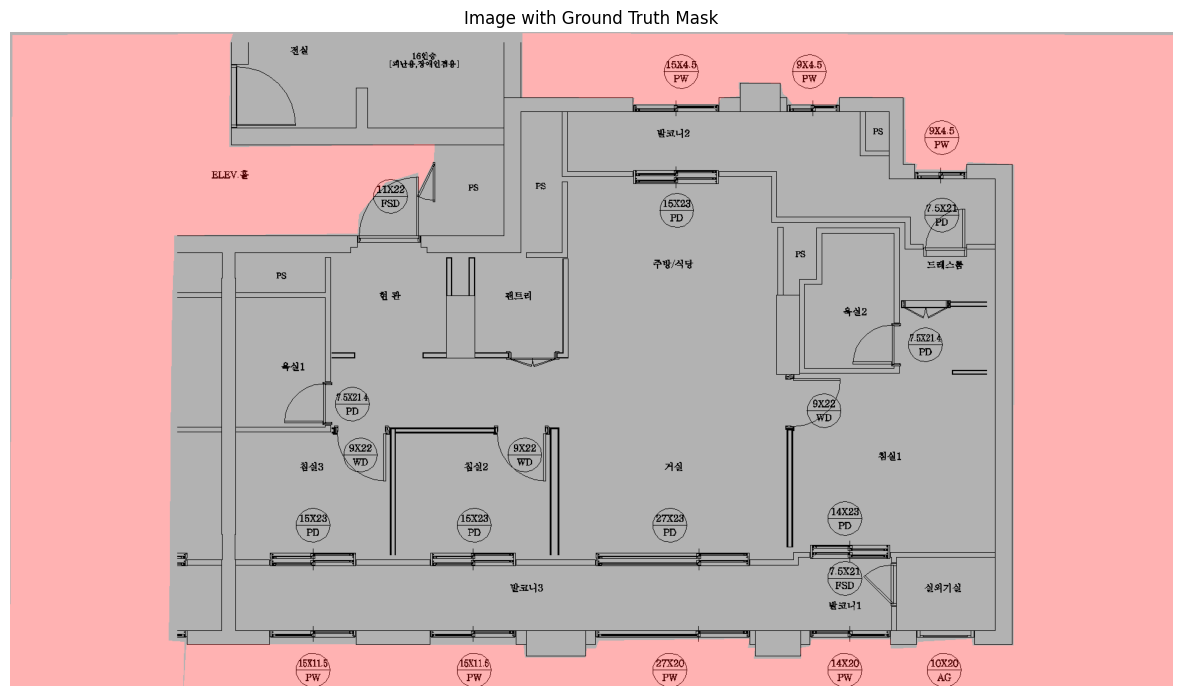

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# JSON 파일을 로드합니다.
json_path = 'TestPrint.json'
with open(json_path, 'r') as f:
    data = json.load(f)

# 이미지를 불러옵니다.
image_path = 'TestPrint.PNG'
image = Image.open(image_path).convert("RGB")
image_np = np.array(image)

# 마스크를 초기화합니다.
mask = np.zeros((image_np.shape[0], image_np.shape[1]), dtype=np.uint8)

# 분류별 색상을 정의합니다.
color_map = {
    'outside': 1,
    # 'cat': 2,
    # 'blanket': 3,
    # 'background': 4,
}

# 마스크 생성
for shape in data['shapes']:
    label = shape['label']
    points = np.array(shape['points'], dtype=np.int32)
    color = color_map.get(label, 0)  # 정의되지 않은 라벨은 0 (배경)으로 설정
    cv2.fillPoly(mask, [points], color)

# 시각화 색상을 정의합니다.
visual_color_map = {
    0: (0, 0, 0),        # 배경은 검정색
    1: (255, 0, 0),      # balcony는 빨간색
    2: (0, 255, 0),      # room은 녹색
    3: (0, 0, 255),      # living_room은 파란색
    4: (255, 255, 0),    # bath_room은 노란색
    5: (255, 0, 255)     # front는 보라색
}

# 색상 마스크 생성
color_mask = np.zeros((image_np.shape[0], image_np.shape[1], 3), dtype=np.uint8)
for label, color in visual_color_map.items():
    color_mask[mask == label] = color

# 원본 이미지와 마스크를 합성합니다.
combined = cv2.addWeighted(image_np, 0.7, color_mask, 0.3, 0)

# 시각화 함수
def plot_segmentation(image):
    plt.figure(figsize=(15, 10))
    plt.title('Image with Ground Truth Mask')
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# 시각화 실행
plot_segmentation(combined)


In [6]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from labelme import utils

def load_image(image_path):
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

def load_json(json_path):
    with open(json_path) as f:
        data = json.load(f)
    return data

def create_mask(label_data, img_shape):
    label_name_to_value = {'_background_': 0}
    for shape in label_data['shapes']:
        label_name = shape['label']
        if label_name in label_name_to_value:
            label_value = label_name_to_value[label_name]
        else:
            label_value = len(label_name_to_value)
            label_name_to_value[label_name] = label_value
    lbl, _ = utils.shapes_to_label(img_shape, label_data['shapes'], label_name_to_value)
    return lbl, label_name_to_value

def apply_mask(image, mask, label_name_to_value, alpha=0.5):
    colors = {label: tuple(np.random.randint(0, 255, 3).tolist()) for label in label_name_to_value.values()}
    output = image.copy()
    for label, color in colors.items():
        output[mask == label] = alpha * np.array(color) + (1 - alpha) * output[mask == label]
    return output

def visualize_and_save_segmentation(image_folder, json_folder, output_folder, alpha=0.5):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg') or f.endswith('.png') or f.endswith('.jpeg') or f.endswith('.PNG')]
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        json_path = os.path.join(json_folder, image_file.replace('.jpg', '.json').replace('.png', '.json'))

        if not os.path.exists(json_path):
            continue

        image = load_image(image_path)
        label_data = load_json(json_path)
        mask, label_name_to_value = create_mask(label_data, image.shape[:2])

        segmented_image = apply_mask(image, mask, label_name_to_value, alpha)

        output_path = os.path.join(output_folder, image_file)
        plt.imsave(output_path, segmented_image)

        print(f'Saved masked image to {output_path}')

# Change these paths to your folders
image_folder = './data/images'
json_folder = './data/json'
output_folder = './data/output'

visualize_and_save_segmentation(image_folder, json_folder, output_folder, alpha=0.2)


Saved masked image to ./data/output\41.png
Saved masked image to ./data/output\43.png
Saved masked image to ./data/output\47.png
Saved masked image to ./data/output\74.png
Saved masked image to ./data/output\75.png
Saved masked image to ./data/output\77.png
Saved masked image to ./data/output\TE_C_00017.png
Saved masked image to ./data/output\TE_C_00018.png
Saved masked image to ./data/output\TE_C_00021.png
Saved masked image to ./data/output\TE_C_00033.png


In [4]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import colorsys
from labelme import utils
from matplotlib.patches import Patch
from matplotlib.colors import to_rgba

def load_image(image_path):
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

def load_json(json_path):
    with open(json_path) as f:
        data = json.load(f)
    return data

def create_mask(label_data, img_shape):
    label_name_to_value = {'_background_': 0}
    for shape in label_data['shapes']:
        label_name = shape['label']
        if label_name in ['non_bearing_wall', 'bearing_wall']:
            label_name = 'wall'
        if label_name in label_name_to_value:
            label_value = label_name_to_value[label_name]
        else:
            label_value = len(label_name_to_value)
            label_name_to_value[label_name] = label_value
        shape['label'] = label_name
    lbl, _ = utils.shapes_to_label(img_shape, label_data['shapes'], label_name_to_value)
    return lbl, label_name_to_value

def generate_colors(num_classes):
    colors = [(240, 248, 255)]  # Very light sky blue (aliceblue) for background
    
    hsv_colors = [(i / (num_classes - 1), 1.0, 1.0) for i in range(num_classes - 1)]
    rgb_colors = [colorsys.hsv_to_rgb(*hsv) for hsv in hsv_colors]
    rgb_colors = [(int(r * 255), int(g * 255), int(b * 255)) for r, g, b in rgb_colors]
    
    return colors + rgb_colors

def apply_mask(image, mask, label_name_to_value, alpha=0.5):
    unique_labels = sorted(list(set(label_name_to_value.values())))
    num_classes = len(unique_labels)
    colors = generate_colors(num_classes)
    label_to_color = {label: colors[i] for i, label in enumerate(unique_labels)}
    
    output = image.copy()
    for label, color in label_to_color.items():
        if label == 0:  # background
            continue  # skip applying mask for background
        output[mask == label] = alpha * np.array(color) + (1 - alpha) * output[mask == label]
    return output, label_to_color

def add_legend(image, label_to_color, label_name_to_value, alpha=0.5):
    legend_elements = []
    for label_name, label in label_name_to_value.items():
        if label in label_to_color:
            color = label_to_color[label]
            # Convert RGB to RGBA with the same alpha value used in the mask
            rgba_color = to_rgba(np.array(color)/255, alpha=alpha)
            legend_elements.append(Patch(facecolor=rgba_color, label=label_name, edgecolor='none'))
    
    # Create figure with extra space for legend
    fig, (ax_image, ax_legend) = plt.subplots(1, 2, figsize=(15, 10), 
                                              gridspec_kw={'width_ratios': [4, 1]})
    
    # Plot image
    ax_image.imshow(image)
    ax_image.axis('off')
    
    # Add legend to the right
    ax_legend.axis('off')
    ax_legend.legend(handles=legend_elements, loc='center left', fontsize='small', 
                     title="Classes", frameon=False)
    
    # Adjust layout and draw
    plt.tight_layout()
    fig.canvas.draw()

    # Convert figure to image
    width, height = fig.canvas.get_width_height()
    image_with_legend = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)

    plt.close(fig)
    return image_with_legend

def visualize_and_save_segmentation(image_folder, json_folder, output_folder, alpha=0.5):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.PNG', '.jpeg'))]
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        json_path = os.path.join(json_folder, os.path.splitext(image_file)[0] + '.json')

        if not os.path.exists(json_path):
            continue

        image = load_image(image_path)
        label_data = load_json(json_path)
        mask, label_name_to_value = create_mask(label_data, image.shape[:2])

        segmented_image, label_to_color = apply_mask(image, mask, label_name_to_value, alpha)
        image_with_legend = add_legend(segmented_image, label_to_color, label_name_to_value, alpha)

        output_path = os.path.join(output_folder, image_file)
        plt.imsave(output_path, image_with_legend)

        print(f'Saved masked image to {output_path}')

# Change these paths to your folders
image_folder = './images'
json_folder = './json'
output_folder = './output'

# Adjust alpha value here for more or less transparency
visualize_and_save_segmentation(image_folder, json_folder, output_folder, alpha=0.3)

C:\Users\sudip\AppData\Local\Temp\ipykernel_27428\2720376891.py:75: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax_legend.legend(handles=legend_elements, loc='center left', fontsize='small',
C:\Users\sudip\AppData\Local\Temp\ipykernel_27428\2720376891.py:84: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image_with_legend = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)


Saved masked image to ./output\25.PNG


In [1]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import colorsys
from labelme import utils
from matplotlib.patches import Patch
from matplotlib.colors import to_rgba

def load_image(image_path):
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

def load_json(json_path):
    with open(json_path) as f:
        data = json.load(f)
    return data

def create_mask(label_data, img_shape):
    label_name_to_value = {'_background_': 0}
    for shape in label_data['shapes']:
        label_name = shape['label']
        if label_name in ['non_bearing_wall', 'bearing_wall']:
            label_name = 'wall'
        if label_name in label_name_to_value:
            label_value = label_name_to_value[label_name]
        else:
            label_value = len(label_name_to_value)
            label_name_to_value[label_name] = label_value
        shape['label'] = label_name
    lbl, _ = utils.shapes_to_label(img_shape, label_data['shapes'], label_name_to_value)
    return lbl, label_name_to_value

def generate_colors(num_classes):
    colors = [(240, 248, 255)]  # Very light sky blue (aliceblue) for background
    
    hsv_colors = [(i / (num_classes - 1), 1.0, 1.0) for i in range(num_classes - 1)]
    rgb_colors = [colorsys.hsv_to_rgb(*hsv) for hsv in hsv_colors]
    rgb_colors = [(int(r * 255), int(g * 255), int(b * 255)) for r, g, b in rgb_colors]
    
    return colors + rgb_colors

def apply_mask(image, mask, label_name_to_value, alpha=0.5):
    unique_labels = sorted(list(set(label_name_to_value.values())))
    num_classes = len(unique_labels)
    colors = generate_colors(num_classes)
    label_to_color = {label: colors[i] for i, label in enumerate(unique_labels)}
    
    output = image.copy()
    for label, color in label_to_color.items():
        if label == 0:  # background
            continue  # skip applying mask for background
        output[mask == label] = alpha * np.array(color) + (1 - alpha) * output[mask == label]
    return output, label_to_color

def add_legend(image, label_to_color, label_name_to_value, alpha=0.5):
    legend_elements = []
    for label_name, label in label_name_to_value.items():
        if label in label_to_color:
            color = label_to_color[label]
            # Convert RGB to RGBA with the same alpha value used in the mask
            rgba_color = to_rgba(np.array(color)/255, alpha=alpha)
            legend_elements.append(Patch(facecolor=rgba_color, label=label_name, edgecolor='none'))
    
    # Create figure with extra space for legend
    fig, (ax_image, ax_legend) = plt.subplots(1, 2, figsize=(15, 10), 
                                              gridspec_kw={'width_ratios': [4, 1]})
    
    # Plot image
    ax_image.imshow(image)
    ax_image.axis('off')
    
    # Add legend to the right
    ax_legend.axis('off')
    ax_legend.legend(handles=legend_elements, loc='center left', fontsize='small', 
                     title="Classes", frameon=False)
    
    # Adjust layout and draw
    plt.tight_layout()
    fig.canvas.draw()

    # Convert figure to image
    width, height = fig.canvas.get_width_height()
    image_with_legend = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)

    plt.close(fig)
    return image_with_legend

def visualize_and_save_segmentation(image_folder, json_folder, output_folder, alpha=0.5):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        json_path = os.path.join(json_folder, os.path.splitext(image_file)[0] + '.json')

        if not os.path.exists(json_path):
            continue

        image = load_image(image_path)
        label_data = load_json(json_path)
        mask, label_name_to_value = create_mask(label_data, image.shape[:2])

        segmented_image, label_to_color = apply_mask(image, mask, label_name_to_value, alpha)
        image_with_legend = add_legend(segmented_image, label_to_color, label_name_to_value, alpha)

        output_path = os.path.join(output_folder, image_file)
        plt.imsave(output_path, image_with_legend)

        print(f'Saved masked image to {output_path}')

# Change these paths to your folders
image_folder = './images'
json_folder = './json'
output_folder = './output'

# Adjust alpha value here for more or less transparency
visualize_and_save_segmentation(image_folder, json_folder, output_folder, alpha=0.3)

C:\Users\sudip\AppData\Local\Temp\ipykernel_27428\1264225586.py:75: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax_legend.legend(handles=legend_elements, loc='center left', fontsize='small',
C:\Users\sudip\AppData\Local\Temp\ipykernel_27428\1264225586.py:84: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image_with_legend = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)


Saved masked image to ./output\25.PNG
